In [114]:
import os,sys,requests,numpy,time,pandas,ssl,scipy
import matplotlib.pyplot as plt
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context
def getRandomN(n,min,max):return numpy.sort((max-min)*numpy.random.random_sample(n)+min)
print('done')

done


In [99]:
image_services = {'MosaicMRF_Albers':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt/ImageServer',
'MRF_Albers':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TreeMap2016_CONUS_StandHt_mrf/ImageServer',
'MosaicMRF_WebMercator':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TM2016_CONUS_StandHt_WMmosaic/ImageServer',
'MRF_WebMercator':'https://ntcfsxopsx1284:6443/arcgis/rest/services/Utilities2/TreeMap2016_CONUS_StandHt_WM_mrf/ImageServer'
}
# image_services = {'LCMS_Albers':'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Most_Recent_Year_Of_Fast_Loss/ImageServer',
#                   'LCMS_WM':'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/LCMS_CONUS_Annual_Landcover/ImageServer'}

service_bounds = [-1.42463587702E7,2604056.207800001,-7264068.770199999,6736796.207800001]

projections = {
    'Albers':102008,
    'WM':3857
}
nTests = 500
exportImage_output_folder = r'X:\03_Outputs\03_Image_Service_Benchmarking\exportImage'
exportImageTable = os.path.join(exportImage_output_folder,'Treemap_ExportImage_Benchmarking_Table_{}.csv'.format(nTests))

In [100]:

def getBenchmarkTable(overwrite=False):
    if not os.path.exists(exportImage_output_folder):os.makedirs(exportImage_output_folder)

    if not os.path.exists(exportImageTable) or overwrite:
        out_table = 'Iteration,Bbox'
        for service_name in list(image_services.keys()):
            for projection_name in projections.keys():
                out_table+=',{} Projection-{} Time'.format(service_name,projection_name)
        out_table+='\n'

        for i in range(1,nTests+1):
            xs = getRandomN(2,service_bounds[0],service_bounds[2])
            ys = getRandomN(2,service_bounds[1],service_bounds[3])
            bbox = [str(i) for i in [xs[0],ys[0],xs[1],ys[1]]]
            bbox_comma_delimited = ','.join(bbox)
            bbox_underscore_delimited = '_'.join(bbox)
            # print(bbox)
            time_list = []
            for service_name in list(image_services.keys()):
                service_path = image_services[service_name]
                
                for projection_name in projections.keys():
                    projection_code = projections[projection_name]
                    

                    exportImageCall = '{}/exportImage?f=image&bbox={}&imageSR={}&bboxSR=102100'.format(service_path,bbox_comma_delimited,projection_code)
                    exportImageName = os.path.join(exportImage_output_folder,'iteration{}_{}_callProj{}.png'.format(i,service_name,projection_name))
                    print(exportImageCall)
                    print(exportImageName)
                    startTime = time.time()
                    urllib.request.urlretrieve(exportImageCall, exportImageName)
                    endTime = time.time()
                    time_list.append(str(endTime-startTime))
            out_table+= '{},{},{}\n'.format(i,bbox_underscore_delimited,','.join(time_list))
            
            print(out_table)
            o = open(exportImageTable,'w')
            o.write(out_table)
            o.close()
print('done')

done


In [102]:
getBenchmarkTable(overwrite=False)

['MosaicMRF_Albers Projection-Albers Time', 'MosaicMRF_Albers Projection-WM Time']
Mean diff: 0.0060987286567688
MAE: 0.05414715909957886
RMSE: 0.21071999724245802
STDev: 0.21063172303010916
Ttest_indResult(statistic=0.572574656657278, pvalue=0.6207584830339321)
['MRF_Albers Projection-Albers Time', 'MRF_Albers Projection-WM Time']
Mean diff: 0.004600058078765871
MAE: 0.03918256807327271
RMSE: 0.11931526513203046
STDev: 0.11922655727311221
Ttest_indResult(statistic=0.27503868170345264, pvalue=0.7884231536926147)
['MosaicMRF_WebMercator Projection-Albers Time', 'MosaicMRF_WebMercator Projection-WM Time']
Mean diff: 0.02266686439514161
MAE: 0.04659200763702393
RMSE: 0.2940246785585787
STDev: 0.293149662902702
Ttest_indResult(statistic=0.2999974614904025, pvalue=0.4930139720558882)
['MRF_WebMercator Projection-Albers Time', 'MRF_WebMercator Projection-WM Time']
Mean diff: 0.021460890769958496
MAE: 0.034723226547241214
RMSE: 0.09753614789100382
STDev: 0.09514583707538485
Ttest_indResult(st

Text(0.5, 0, 'Diff Seconds')

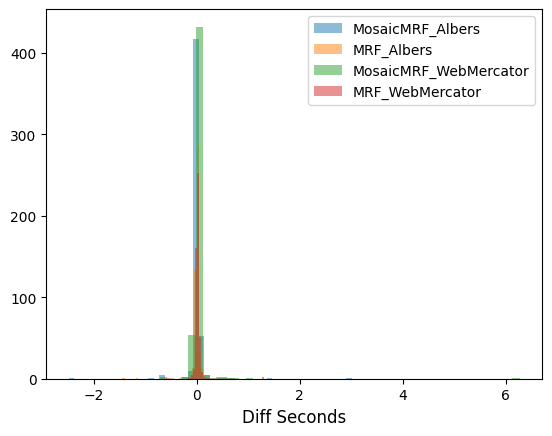

In [122]:
t = pandas.read_csv(exportImageTable)
# print(t)
plots = []
for service_name in list(image_services.keys()):
    field_list = []
    for projection_name in projections.keys():
        field_name = '{} Projection-{} Time'.format(service_name,projection_name)
        field_list.append(field_name)
    print(field_list)
    diff = t[field_list[0]]-t[field_list[1]]
    mean = numpy.mean(diff)
    mae = numpy.mean(numpy.absolute(diff))
    rmse = numpy.sqrt(numpy.mean(numpy.square(diff)))
    std = numpy.std(diff)
    print('Mean diff:',mean)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('STDev:',std)
    ttest = scipy.stats.ttest_ind(t[field_list[0]], t[field_list[1]], axis=0, equal_var=False, nan_policy='propagate', permutations=500, random_state=None, alternative='two-sided', trim=0)
    print(ttest)
#     t.plot.scatter(field_list[0],field_list[1],alpha=0.5)
    plt.hist(diff,50,alpha=0.5,label=service_name,density=False)
plt.legend()
plt.xlabel("Diff Seconds", size=12)
# plt.xlim(-.5,0.5)
#     print(t[field_list])

#     plots.append(plt.hist(t[field_list]))
    
# print(plots)